In [2]:
#Imports
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid
from dm_control.locomotion.arenas import corridors as corridor_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os
from collections import deque
from keras.callbacks import TensorBoard
import time
import random
#HELPER FUNCTION

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

C:\Users\lukem\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib_inline\config.py:66: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


In [3]:
#Helper functions

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
%config InlineBackend.figure_format = 'svg'
# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    anim.save('cartpole.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
    
class ModifiedTensorBoard(TensorBoard):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.create_file_writer(self.log_dir)
        self._log_write_dir = self.log_dir
    
    def set_model(self, model):
        self.model = model
    
        self._train_dir = os.path.join(self._log_write_dir, 'train')
        self._train_step = self.model._train_counter
    
        self._val_dir = os.path.join(self._log_write_dir, 'validation')
        self._val_step = self.model._test_counter
    
        self._should_write_train_graph = False
    
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)
    
    def on_batch_end(self, batch, logs=None):
        pass
    
    def on_train_end(self, _):
        pass
    
    def update_stats(self, **stats):
        with self.writer.as_default():
            for key, value in stats.items():
                tf.summary.scalar(key, value, step = self.step)
                self.writer.flush()


In [4]:
#DQN agent

class DQN_agent():
    def __init__(self):
        self.model = self.create_model()
        
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())
        
        self.replay_memory = deque(maxlen=1500)
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format('cartpole', int(time.time())))
        self.target_update_counter = 0
        
    def create_model(self):
        model = Sequential()
        model.add(Input(shape=(5,)))
        model.add(Dense(30))
        model.add(Activation('relu'))
        model.add(Dense(60))
        model.add(Activation('relu'))
        model.add(Dense(30))
        model.add(Activation('relu'))
        
        model.add(Dense(3))
        model.add(Activation('sigmoid'))
        
        model.compile(loss = 'mse', optimizer=Adam(lr = 0.001)
                      )
        return model

    def update_replay_memory(self,transition):
        self.replay_memory.append(transition)
        
    def get_qs(self,state):
        return self.model.predict(np.array(state))[0]
    
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < 1500:
            return
        
        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, 500)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])
        future_qs_list = self.target_model.predict(new_current_states)
        
        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + 0.99 * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X), np.array(y), batch_size=500, verbose=1, shuffle=False, callbacks=[self.tensorboard] if terminal_state else None)
        
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > 5:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0
        self.replay_memory = deque(maxlen=1500)
agent = DQN_agent()

C:\Users\lukem\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
#EPISODE

# Load the environment
def run_episode(epsilon,film,step,ep_num):
  env = suite.load('cartpole', 'balance')

  duration = 3 # Seconds
  frames = []
  ticks = []
  rewards = []
  observations = []
  time_step = env.reset()
  
  while env.physics.data.time < duration:
    transition = []
    observation = time_step.observation
    current_state = np.append(list((observation.items()))[0][1],list((observation.items()))[1][1])
    transition.append(current_state)
    attempt = np.argmax(agent.get_qs(current_state.reshape(-1,5)))
    transition.append(attempt)
    if np.random.random()>epsilon:
      if np.argmax(attempt) == 0:
        action =1
      elif np.argmax(attempt) ==1:
        action =-1
      elif np.argmax(attempt)==2:
        action = 0 
    else:
      action = np.random.uniform(low = -1,high = 1)
    time_step = env.step(action)
    observation = time_step.observation
    new_current_state = np.append(list((observation.items()))[0][1],list((observation.items()))[1][1])
    transition.append(time_step.reward)
    transition.append(new_current_state)
    transition.append(False)
    
    agent.update_replay_memory(transition)
    done = False
    agent.train(done,step)
    current_state = new_current_state
    
  
  
  done = True
  transition[-1]=done
  agent.update_replay_memory(transition)
  agent.train(done,step)
  step+=1
  
  if film == True:
    html_video = display_video(frames, framerate=1./env.control_timestep())

    # Show video and plot reward and observations
    num_sensors = len(time_step.observation)

    _, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
    ax[0].plot(ticks, rewards)
    ax[0].set_ylabel('reward')
    ax[-1].set_xlabel('time')

    for i, key in enumerate(time_step.observation):
      data = np.asarray([observations[j][key] for j in range(len(observations))])
      ax[i+1].plot(ticks, data, label=key)
      ax[i+1].set_ylabel(key)

    html_video


In [10]:
#training loop
num_episodes = 200
epsilon = 1
decay = 0.98
min_epsilon = 0.001
step = 1
ep_num = 1
for episode in range(1,num_episodes+1):
    agent.tensorboard.step = episode
    done = False
    print(f"Episode {ep_num}")
    
    run_episode(epsilon,False,step,ep_num)
        
    if epsilon*decay > min_epsilon:
        epsilon = epsilon*decay
    ep_num+=1
run_episode(epsilon,True,ep_num)


Episode 1
Episode 2
Episode 3
1/1 [==============================] - 0s 7ms/step - loss: 0.1444
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
1/1 [==============================] - 0s 4ms/step - loss: 0.0981
Episode 9
Episode 10
Episode 11
Episode 12
Episode 13
1/1 [==============================] - 0s 7ms/step - loss: 0.0640
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
1/1 [==============================] - 0s 7ms/step - loss: 0.0510
Episode 19
Episode 20
Episode 21
Episode 22
Episode 23
1/1 [==============================] - 0s 9ms/step - loss: 0.0371
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
1/1 [==============================] - 0s 3ms/step - loss: 0.0318
Episode 29
Episode 30
Episode 31
Episode 32
Episode 33
1/1 [==============================] - 0s 6ms/step - loss: 0.0251
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
1/1 [==============================] - 0s 5ms/step - loss: 0.0294
Episode 39
Episode 40
Episode 41
Episode 42
Episode 43
1/1 [===

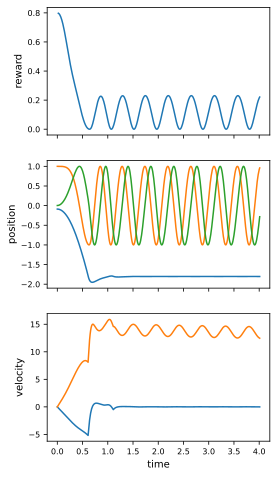

In [ ]:
env = suite.load('cartpole', 'balance',visualize_reward=True)
duration = 4  # Seconds
frames = []
ticks = []
rewards = []
observations = []
done = False
while env.physics.data.time < duration:
  transition = []
  observation = time_step.observation
  current_state = np.append(list((observation.items()))[0][1],list((observation.items()))[1][1])
  transition.append(current_state)
  attempt=agent.get_qs(current_state.reshape(-1,5))
  transition.append(attempt)
  if np.argmax(attempt) == 0:
      action =1
  elif np.argmax(attempt) ==1:
      action =-1
  elif np.argmax(attempt)==2:
      action = 0 
  rewards.append(time_step.reward)
  time_step = env.step(action)
  observation = time_step.observation
  new_current_state = np.append(list((observation.items()))[0][1],list((observation.items()))[1][1])
  transition.append(time_step.reward)
  transition.append(new_current_state)
  transition.append(False)
  
  camera0 = env.physics.render(camera_id=0, height=200, width=200)
  camera1 = env.physics.render(camera_id=1, height=200, width=200)
  frames.append(np.hstack((camera0, camera1)))
  observations.append(copy.deepcopy(time_step.observation))
  ticks.append(env.physics.data.time)

  current_state = new_current_state


html_video = display_video(frames, framerate=1./env.control_timestep())
#Show video and plot reward and observations
num_sensors = len(time_step.observation)
_, ax = plt.subplots(1 + num_sensors, 1, sharex=True, figsize=(4, 8))
ax[0].plot(ticks, rewards)
ax[0].set_ylabel('reward')
ax[-1].set_xlabel('time')
for i, key in enumerate(time_step.observation):
  data = np.asarray([observations[j][key] for j in range(len(observations))])
  ax[i+1].plot(ticks, data, label=key)
  ax[i+1].set_ylabel(key)

html_video
